In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
file= r'/content/drive/My Drive/AdSmartABdata.csv'
import pandas as pd
data = pd.read_csv(file)

In [6]:
%matplotlib inline
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data visualization

In [7]:
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [8]:
for col in data.columns:
  print(col,':', data[col].nunique(), 'labels')

auction_id : 8077 labels
experiment : 2 labels
date : 8 labels
hour : 24 labels
device_make : 270 labels
platform_os : 3 labels
browser : 15 labels
yes : 2 labels
no : 2 labels


#Feature engineering

In [21]:
#Drop auction_id since it is unique to every data and no prediction value
data.drop('auction_id', axis=1, inplace=True)

In [22]:
#Merge yes and no columns into converted(0 for no/1 for yes)
a =pd.DataFrame(data[(data['yes']==1)]) 
b =pd.DataFrame(data[(data['no']==1)])
b['no']=0
df = pd.concat([a, b]).sort_index()
df. drop(['no'], axis=1, inplace=True)
df.rename(columns = {'yes':'converted'}, inplace = True) 
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0


In [23]:
from sklearn import preprocessing 
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in all columns. 
df['experiment']= label_encoder.fit_transform(df['experiment'])
df['date']= label_encoder.fit_transform(df['date'])
df['device_make']= label_encoder.fit_transform(df['device_make'])
df['browser']= label_encoder.fit_transform(df['browser'])
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,1,2,2,4,6,2,0
16,1,1,16,13,6,1,1
20,1,3,8,13,6,1,0
23,0,5,4,43,6,4,1
27,0,0,15,13,6,1,0


In [24]:
#Number of unique values for aech column
for col in df.columns:
  print(col,':', df[col].nunique(), 'labels')

experiment : 2 labels
date : 8 labels
hour : 24 labels
device_make : 115 labels
platform_os : 2 labels
browser : 8 labels
converted : 2 labels


In [25]:
#Drop device_make
data.drop('device_make', axis=1, inplace=True)

In [26]:
#standardize the data so that exaggerated values don't affect our model(logistic regression)
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
df[:1243] = scaling.fit_transform(df[:1243])

In [28]:
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,1.0,0.285714,0.086957,0.035088,1.0,0.285714,0.0
16,1.0,0.142857,0.695652,0.114035,1.0,0.142857,1.0
20,1.0,0.428571,0.347826,0.114035,1.0,0.142857,0.0
23,0.0,0.714286,0.173913,0.377193,1.0,0.571429,1.0
27,0.0,0.000000,0.652174,0.114035,1.0,0.142857,0.0


#Splitting data

In [29]:
#split data into 70% training, 20% validation and 10% test data
train, validate, test = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

In [30]:
#specify the features and target variable for train set
x_train = train[['experiment', 'date', 'hour',  'platform_os', 'browser']]
y_train = train['converted']

#specify the features and target variable for validation data
x_validate = validate[['experiment', 'date', 'hour', 'platform_os', 'browser']]
y_validate = validate['converted']

#specify the features and target variable for test data
x_test = test[['experiment', 'date', 'hour', 'platform_os', 'browser']]
y_test = test['converted']

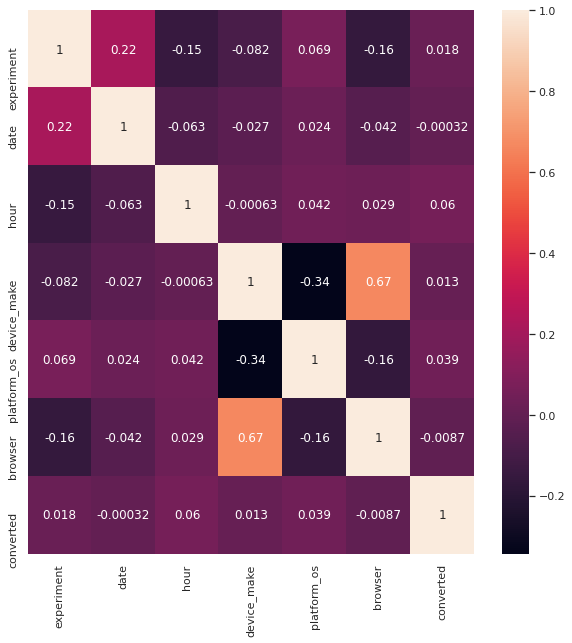

In [31]:
#correlation among the features
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g = sns.heatmap(df[top_corr_features].corr(), annot= True)

#Modeling

In [34]:
#Import modeling algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [35]:
#import cross_validation library
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


##Logistic regression

In [36]:
#train logistic regression model
log_model = LogisticRegression()
log_model.fit(x_train,y_train)
#calculate average accuracy score 
print(cross_val_score(log_model, x_train, y_train,cv=k_fold, scoring= 'accuracy').mean())

0.5149425287356322


In [38]:
#import log_loss
from sklearn.metrics import log_loss
model = log_model
# predict probabilities
probs = model.predict_proba(x_validate)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss using validation data
loss = log_loss(y_validate, probs)
loss

0.688243792569509

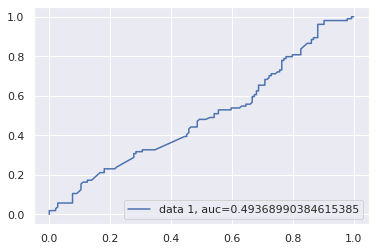

In [47]:
y_pred_proba = log_model.predict_proba(x_validate)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_validate,  y_pred_proba)
auc = metrics.roc_auc_score(y_validate, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [42]:
#predict values using testing data
prediction = log_model.predict(x_test)
predicted_values = pd.DataFrame({
           "experiment" : test['experiment'],
           "converted" : prediction})

In [43]:
predicted_values.head()

,experiment,converted
2675,1.0,0.0
3444,0.0,0.0
1437,1.0,1.0
5691,0.0,0.0
7451,1.0,0.0


In [44]:
#confusion matris
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[55,  8],
       [47, 15]])

##Decision tree

In [45]:
#train decision tree model
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
print(cross_val_score(dt, x_train, y_train,cv= 5, scoring= 'accuracy').mean())

0.44482758620689655


In [46]:
from sklearn.metrics import log_loss
model = dt
# predict probabilities
probs = model.predict_proba(x_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

9.161035149941537

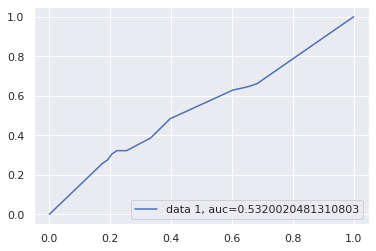

In [48]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

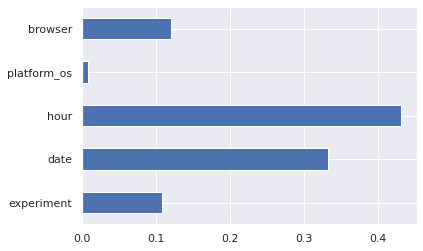

In [50]:
#feature importance
feat_importance = pd.Series(dt.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

In [53]:
#predict using testing data
prediction = dt.predict(x_test)
predicted_values = pd.DataFrame({
           "experiment" : test['experiment'],
           "yes" : prediction})

In [54]:
predicted_values.head()

,experiment,yes
2675,1.0,1.0
3444,0.0,1.0
1437,1.0,1.0
5691,0.0,0.0
7451,1.0,0.0


In [56]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[42, 21],
       [38, 24]])

##XGBoost

In [57]:
#train XGBoost 
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
xg_reg = xgb.XGBClassifier()
xg_reg.fit(x_train,y_train)
#calculate average accuracy 
print(cross_val_score(xg_reg, x_train, y_train,cv= 5, scoring= 'accuracy').mean())


0.45862068965517244


In [58]:
from sklearn.metrics import log_loss
model = xg_reg
# predict probabilities
probs = model.predict_proba(x_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

0.6825757329463958

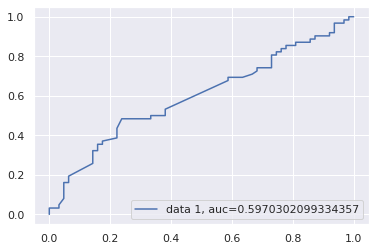

In [59]:

y_pred_proba = xg_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

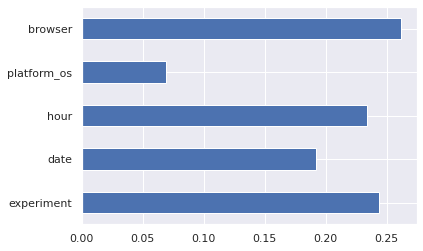

In [60]:
#feature importance for XGBoost model
feat_importance = pd.Series(xg_reg.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

In [62]:
#predict using testind data
prediction = xg_reg.predict(x_test)
submission = pd.DataFrame({
    "experiment" : test['experiment'],
    "converted" : prediction
})

In [63]:
submission.head()

,experiment,converted
2675,1.0,0.0
3444,0.0,1.0
1437,1.0,1.0
5691,0.0,0.0
7451,1.0,0.0


In [64]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[45, 18],
       [32, 30]])